Importing the Libraries to perform the classification

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Directory where the images are stored

In [2]:
PATH1 =os.getcwd()+'/Skin_Cancer/train_dir'

In [3]:
PATH2 = os.getcwd()+'/Skin_Cancer/val_dir'


In [4]:
os.listdir(PATH1)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

In [5]:
os.listdir(PATH2)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

Creating our Datasets for the analysis purpose by prerocessing the Dataset.

In [6]:


datagen=ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Build for training
trainGeneratorBuild = datagen.flow_from_directory(
    PATH1,
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 10,
    shuffle= True
)
# Build for test
testGeneratorBuild = datagen.flow_from_directory(
    PATH2,
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 10,
    shuffle=True
)

Found 38568 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


Exploratory Data Analysis

In [7]:
class_names = trainGeneratorBuild .class_indices
print(class_names)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
classes = list(class_names.keys())
print(classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [9]:
images,labels = next(trainGeneratorBuild)
labels = np.argmax(labels, axis=1)
class_dict = trainGeneratorBuild.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

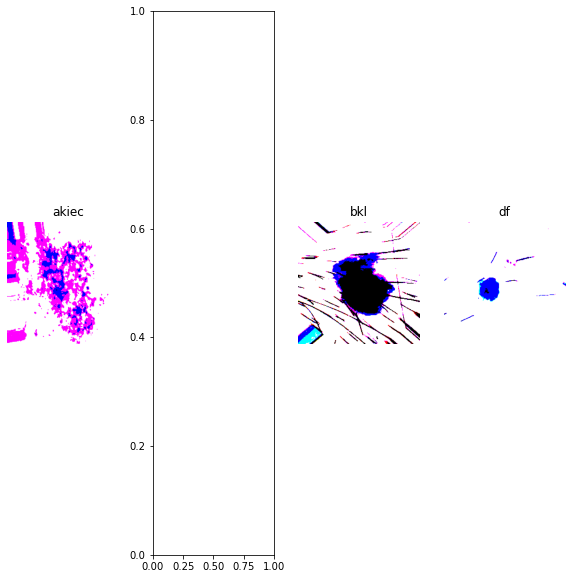

In [10]:
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1

Using transfer learning to train the model using VGG16

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16 #importing the model.


In [17]:
vgg  = VGG16( input_shape=(224,224,3), include_top=False) #using the final layer of resnet50 for our model to train.

In [19]:
for layer in vgg.layers:      #setting all the training layers of vgg16 to false.
    layer.trainable = False


In [20]:
from tensorflow.keras import Model

Creating the model using Functional API model.

In [21]:
x = vgg.output
x = GlobalAveragePooling2D()(x) #applying global max pooling to all output of vgg16 layers.

#adding custom fully connected layers to the vgg16 layers
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out = layers.Dense(7, activation='softmax')(x)


# Creating our model
model = Model(inputs=vgg.input, outputs=out)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #compiling the model.

In [24]:
early_stop = EarlyStopping(monitor='val_loss',  # early stopping to prevent the model to train further if the learning rate does not improve.
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)


Setting our Checkpoint for finding the best fit from epoch and save it in h5 format

In [25]:
filepath = "/Users/aqdus/desktop/Skin/vgg16_model.h5"  # destination to save our model
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [26]:
# Add weights to try to make the model more sensitive to melanoma

class_weights = {
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0,  # nv
    6: 1.0,  # vasc
}


In [29]:
#fitting the model.
history=model.fit(trainGeneratorBuild,batch_size=10, epochs=10, validation_data=testGeneratorBuild,callbacks = [early_stop,mc],verbose=1,class_weight=class_weights,steps_per_epoch=908,validation_steps=94)

Epoch 1/10
908/908 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.6047

2022-04-25 12:33:01.556358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


908/908 [==============================] - 181s 199ms/step - loss: 1.2467 - accuracy: 0.6047 - val_loss: 0.6100 - val_accuracy: 0.7804

Epoch 00001: val_loss improved from inf to 0.61001, saving model to /Users/aqdus/desktop/Skin/vgg16_model.h5
Epoch 2/10
908/908 [==============================] - 184s 203ms/step - loss: 1.1292 - accuracy: 0.6349 - val_loss: 0.5431 - val_accuracy: 0.8038

Epoch 00002: val_loss improved from 0.61001 to 0.54309, saving model to /Users/aqdus/desktop/Skin/vgg16_model.h5
Epoch 3/10
908/908 [==============================] - 192s 211ms/step - loss: 1.0567 - accuracy: 0.6669 - val_loss: 0.6222 - val_accuracy: 0.7495

Epoch 00003: val_loss did not improve from 0.54309
Epoch 4/10
908/908 [==============================] - 201s 221ms/step - loss: 0.9844 - accuracy: 0.6835 - val_loss: 0.5254 - val_accuracy: 0.7985

Epoch 00004: val_loss improved from 0.54309 to 0.52539, saving model to /Users/aqdus/desktop/Skin/vgg16_model.h5
Epoch 5/10
908/908 [=================

Calculating the overall Validation score

In [31]:
print("Test score:", model.evaluate(testGeneratorBuild))
n_epochs = len(history.history['loss'])

94/94 [==============================] - 23s 246ms/step - loss: 0.4779 - accuracy: 0.8305
Test score: [0.47788435220718384, 0.8304904103279114]


Plotting
1. Training and Validation accuracy
2. Training and Validation loss

In [32]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

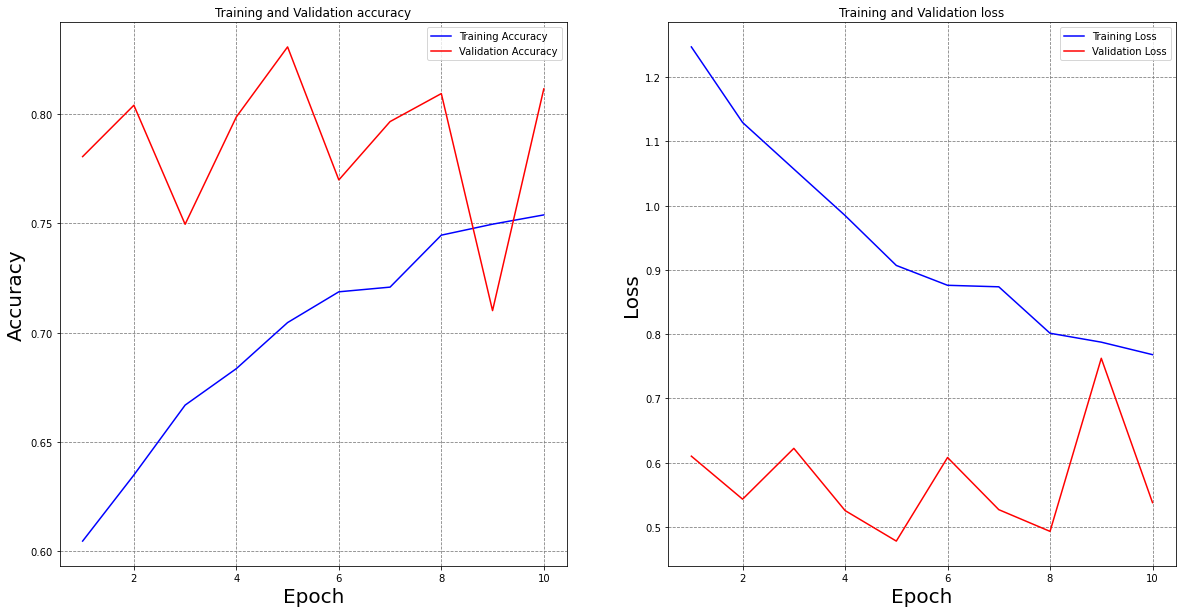

In [33]:
plotLearningCurve(history,n_epochs)

Taking a sample and visulizing the effieciency of the model created from transfer learning (Resnet50) on a test image sample.

In [34]:
from tensorflow.keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

2022-04-25 13:10:00.030853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The given Skin_Cancer image is of type = nv

The chances of image being akiec is : 1.8057599504572863e-05 percent

The chances of image being bcc is : 2.3325760878378787e-05 percent

The chances of image being bkl  is : 8.456683158874512 percent

The chances of image being df is : 1.4592792838811874 percent

The chances of image being mel is : 0.04966390551999211 percent

The chances of image being nv  is : 90.03431797027588 percent

The chances of image being vasc is : 1.8718181138410728e-05 percent



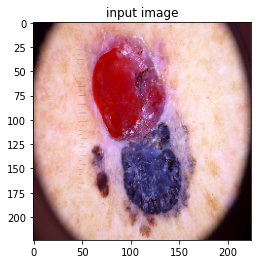

In [35]:
# path for that new image.
PATH = os.getcwd()+'/ISIC_0025234.jpg'
# you can add any image path
img = get_img_array(PATH)
'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'
res = classes[np.argmax(model.predict(img))]
print(f"The given Skin_Cancer image is of type = {res}")
print()
print(f"The chances of image being akiec is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being bcc is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being bkl  is : {model.predict(img)[0][2]*100} percent")
print()
print(f"The chances of image being df is : {model.predict(img)[0][3]*100} percent")
print()
print(
    f"The chances of image being mel is : {model.predict(img)[0][4]*100} percent")
print()
print(
    f"The chances of image being nv  is : {model.predict(img)[0][5]*100} percent")
print()
print(
    f"The chances of image being vasc is : {model.predict(img)[0][6]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()
